# MS-Zang-optimize-v2

In [1]:
%cd /Users/wangcaini/IAMS-Rydberg-atom-quantum-computing-main

/Users/wangcaini/IAMS-Rydberg-atom-quantum-computing-main


In [2]:
from IPython.display import clear_output

from qutip import *
import math

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from rdquantum.fidelity import fidelity
from rdquantum.optimizer.de import de
from rdquantum.pulse_shape import MS_pulse_shape
import time
start=time.time()

In [3]:
Tg=2.0
point=1000
times = np.linspace(0.0, Tg, point)



# Physical system

In [4]:
### Hamiltonian ###
def Hamiltonian(shape_omega1, omega2, delta1, delta2):
    omega2=omega2[0]
    delta1=delta1[0]
    delta2=delta2[0]
    
    rho = []    # 0, 1, p, r, d
    for i in range(5):
        rho.append(ket2dm(basis(5,i)))

    I = qeye(5)
    H_omega1 = np.zeros((5,5))
    H_omega1[2][1] = 2*np.pi / 2
    H_omega1[1][2] = 2*np.pi / 2
    H_omega1 = Qobj(H_omega1)

    H_omega2 = np.zeros((5,5))
    H_omega2[3][2] = 2*np.pi / 2
    H_omega2[2][3] = 2*np.pi / 2
    H_omega2 = Qobj(omega2*H_omega2)

    H_delta1 = np.zeros((5,5))
    H_delta1[2][2] = 2*np.pi
    H_delta1 = Qobj(delta1*H_delta1)
    
    H_delta2 = np.zeros((5,5))
    H_delta2[3][3] = 2*np.pi
    H_delta2 = Qobj(delta2*H_delta2)

    B = 2*np.pi * 500           # (MHz) Strength of Rydberg states interaction
    Brr = np.zeros((5,5))
    Brr[3][3] = 1
    Brr = tensor(B*Qobj(Brr), Qobj(Brr))

    H = [[tensor(H_omega1, I) + tensor(I, H_omega1), shape_omega1], [tensor(H_omega2, I) + tensor(I, H_omega2), '1'], [tensor(H_delta1, I) + tensor(I, H_delta1), '1'], [tensor(H_delta2, I) + tensor(I, H_delta2), '1'], [Brr, '1']]

    return H




#Decay term
c_ops = []
I = qeye(5)
gammar = 1/540      #unit:1/(mu s)         
gammap = 1/0.155

L0p = np.zeros((5,5))
L0p[0][2] = np.sqrt(1/16 * gammap)
c_ops.append(tensor(Qobj(L0p), I))
c_ops.append(tensor(I, Qobj(L0p)))

L0r = np.zeros((5,5))
L0r[0][3] = np.sqrt(1/32 * gammar)
c_ops.append(tensor(Qobj(L0r), I))
c_ops.append(tensor(I, Qobj(L0r)))

L1p = np.zeros((5,5))
L1p[1][2] = np.sqrt(1/16 * gammap)
c_ops.append(tensor(Qobj(L1p), I))
c_ops.append(tensor(I, Qobj(L1p)))

L1r = np.zeros((5,5))
L1r[1][3] = np.sqrt(1/32 * gammar)
c_ops.append(tensor(Qobj(L1r), I))
c_ops.append(tensor(I, Qobj(L1r)))

Ldp = np.zeros((5,5))
Ldp[4][2] = np.sqrt(7/8 * gammap)
c_ops.append(tensor(Qobj(Ldp), I))
c_ops.append(tensor(I, Qobj(Ldp)))

Ldr = np.zeros((5,5))
Ldr[4][3] = np.sqrt(7/16 * gammar)
c_ops.append(tensor(Qobj(Ldr), I))
c_ops.append(tensor(I, Qobj(Ldr)))

Lpr = np.zeros((5,5))
Lpr[2][3] = np.sqrt(1/2 * gammar)
c_ops.append(tensor(Qobj(Lpr), I))
c_ops.append(tensor(I, Qobj(Lpr)))



### Initial state, rhoi() ###
def init_state(rhoc, rhot):
    return tensor(ket2dm(basis(5,rhoc)), ket2dm(basis(5,rhot)))


# Gate Operation

In [5]:
#single qubit ratation gate

def Rxy(theta,phi):
    f = 1j*np.zeros((5,5))
    f[0][0] = np.cos(theta/2)
    f[0][1] = 1j*(np.e**(1j*phi))*np.sin(theta/2)
    f[1][0] = 1j*(np.e**(-1j*phi))*np.sin(theta/2)
    f[1][1] = np.cos(theta/2)
    f=Qobj(f)   
    return f

In [6]:
#single qubit phase gate

def single_phase_gate(singleQB_phase):
    single_PhaseGate = 1j*np.zeros((5,5))
    single_PhaseGate[0][0]=1
    single_PhaseGate[1][1]=np.exp(-1j*singleQB_phase)
    single_PhaseGate[2][2]=1
    single_PhaseGate[3][3]=1
    single_PhaseGate[4][4]=1
    single_PhaseGate=Qobj(single_PhaseGate)
    return single_PhaseGate

In [7]:
# Gate operation

def GateOp(Pulses, rho_init, targets):

    beta_series=Pulses['beta_series']
    n=Pulses['n']
    omega2=Pulses['omega2']
    delta1=Pulses['delta1']
    delta2=Pulses['delta2']
    
    shape_omega1 = MS_pulse_shape(times, Tg, beta_series, n)
    H=Hamiltonian(shape_omega1, omega2, delta1, delta2)
    
    rho1000=tensor(basis(5,0), basis(5,0))*dag(tensor(basis(5,1), basis(5,0)))
    result = mesolve(H, rho_init, times, c_ops, options=Options(nsteps=5000))
    final_state=result.states[-1]
    singleQB_phase=np.angle(expect(rho1000, final_state))-np.pi/2
    single_PhaseGate=single_phase_gate(singleQB_phase)
    
    SinglePhase_rotation=tensor(single_PhaseGate,single_PhaseGate)
    final_gate=tensor(Rxy(3*np.pi/4,singleQB_phase), Rxy(3*np.pi/4,singleQB_phase))
    Foperator=final_gate*SinglePhase_rotation*targets*dag(SinglePhase_rotation)*dag(final_gate)
    F=expect(Foperator,final_state)
    
    return F

# Outpout

In [8]:
beta_series = [206.4, 90.1, 300.5, 195.97]  
n = [9]
omega2 = [50]
delta1 = [-5687]
delta2 = [1.5]
Pulses = {'beta_series': beta_series, 'n': n, 'omega2': omega2, 'delta1': delta1, 'delta2': delta2}
PulsesRange = {'beta_series': [0, 400], 'n': [5,13], 'omega2': [10, 100], 'delta1': [-9000, -4000], 'delta2': [-5, 5]}

I = qeye(5)
bell10 = (1/np.sqrt(2)) * ( tensor(basis(5,0), basis(5,0)) + tensor(basis(5,1), basis(5,1)) )
rho_bell10 = ket2dm(bell10)
rhoi = tensor(Rxy(np.pi/2,0), Rxy(np.pi/2,0)) * init_state(0,0) * dag(tensor(Rxy(np.pi/2,0), Rxy(np.pi/2,0)))

bell_fidelity = fidelity(GateOp) 
print(bell_fidelity.get_fidelity(Pulses, rhoi, rho_bell10))

0.9737129911974418


# Differentail Evolution

In [9]:
K = len(Pulses) 
diffevo = de(bell_fidelity, rhoi, rho_bell10) 
diffevo.createPopulations(Pulses, PulsesRange)
diffevo.start(itr=1, batch=3)

Number of control parameters: 8
Populations size: 120
Start differential evolution...
Iterations: 1
Optimized fidelity: 0
# 1 batch iteration.

Fidelity (Ci, Di) = 0.36761463130681055 0.4953759779470497, population 70 unchanged
Fidelity (Ci, Di) = 0.3104297679575158 0.4421792114515819, population 23 unchanged
Optimized Fidelity: 0.49537597794704974 0.5362143818914253, population 51 unchanged


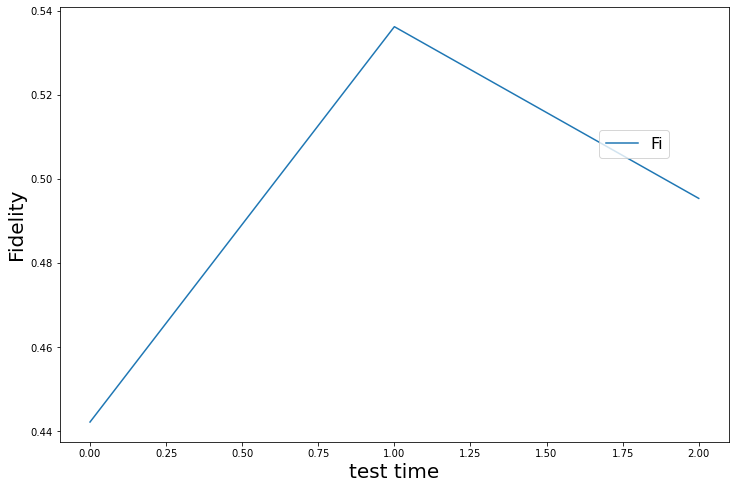

In [10]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(diffevo.data_fidelity, label="Fi")

ax1.set_xlabel("test time", fontsize=20) 
ax1.set_ylabel("Fidelity", fontsize=20)

fig.legend(bbox_to_anchor=(.84, .68), fontsize=16)

In [11]:
op_pulse=diffevo.op_pulse
print(diffevo.op_pulse)
print(diffevo.op_fidelity)

{'beta_series': array([387.28410826,  25.1234072 , 107.33443859, 337.16894787]), 'n': array([8.85554345]), 'omega2': array([36.18900556]), 'delta1': array([-8137.16071246]), 'delta2': array([2.9938821])}
0.4953759779470497


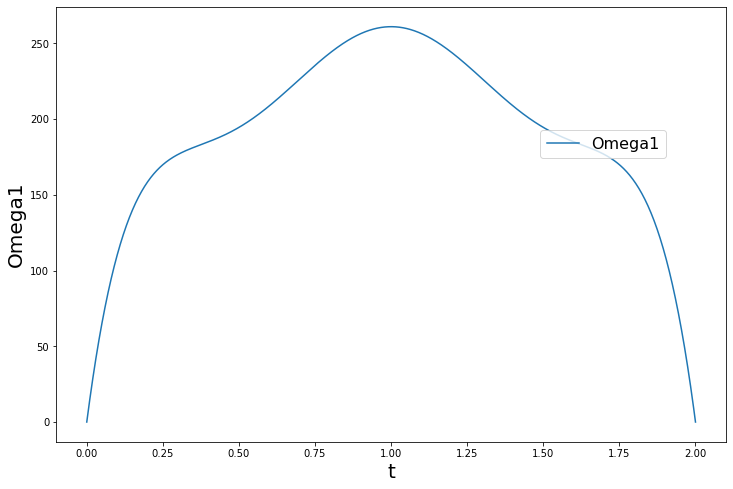

In [12]:
beta_series=op_pulse['beta_series']
n=op_pulse['n']
shape_omega1 = MS_pulse_shape(times, Tg, beta_series, n)

fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(times, shape_omega1, label="Omega1")

ax1.set_xlabel("t", fontsize=20) 
ax1.set_ylabel("Omega1", fontsize=20)

fig.legend(bbox_to_anchor=(.84, .68), fontsize=16)